In [19]:
## import modules
import pandas as pd
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA

## Align Data

In [2]:
## read the data 
datafile = "../data/"
var_lists = ["real_interest_rate","capacity_util","CPI","stickyCPI","PCE", "fed_fund_rate","unemploy_rate",
    "employ_level_nonagri", "employ_level", "housing_started","housing_completed","GDP","personal_saving_rate",
            "avg_house_prices","mortgage"]

homeprice_index = pd.read_csv(datafile +"national_home_price_index.csv")
homeprice_index.rename(columns = {"value":"national_home_price_index"}, inplace = True)
aligned_data = homeprice_index.copy()
homeprice_index

,date,national_home_price_index
0,1987-01-01,63.735
1,1987-02-01,64.135
2,1987-03-01,64.470
3,1987-04-01,64.973
4,1987-05-01,65.547
...,...,...
434,2023-03-01,297.318
435,2023-04-01,301.462
436,2023-05-01,305.421
437,2023-06-01,308.316


In [3]:
## append more date before 
date_app = pd.DataFrame(["1986-{:02d}-01".format(i) for i in range(1,13)], columns = ["date"])
aligned_data = pd.concat([date_app,aligned_data], axis =0)

In [4]:
## align the data
for val in var_lists:
    value = pd.read_csv(datafile + val +".csv")
    value.rename(columns = {"value":val}, inplace = True)
    ## adjust for the GDP look-ahead problem - delay by one quarter 
    if val == "GDP":
        value = pd.concat([value,pd.DataFrame([{"date":"2023-07-01", "GDP": np.nan}])], axis = 0)
        value["GDP_incre_lastQuarter"] = np.log(value["GDP"]).diff().shift(1)
        aligned_data = pd.merge(aligned_data, value, how = "left", on = ["date"])
        aligned_data["GDP_incre_lastQuarter"] = aligned_data["GDP_incre_lastQuarter"].ffill()
    else:
        aligned_data = pd.merge(aligned_data, value, how = "left", on = ["date"])
aligned_data["date"] = aligned_data["date"].apply(lambda x: pd.to_datetime(x))
aligned_data

,date,national_home_price_index,real_interest_rate,capacity_util,CPI,stickyCPI,PCE,fed_fund_rate,unemploy_rate,employ_level_nonagri,employ_level,housing_started,housing_completed,GDP,GDP_incre_lastQuarter,personal_saving_rate,avg_house_prices,mortgage
0,1986-01-01,NaN,4.547185,79.5636,109.900,0.487140,2827.1,8.14,6.7,105600,108887,1972.0,1723.0,4507.894,0.012982,8.7,86600.0,10.8860
1,1986-02-01,NaN,4.623880,78.9134,109.700,0.363870,2820.2,7.86,7.2,105397,108480,1848.0,1753.0,NaN,0.012982,9.3,89700.0,10.7100
2,1986-03-01,NaN,4.209182,78.2664,109.100,0.488280,2823.6,7.48,7.2,105637,108837,1876.0,1756.0,NaN,0.012982,9.9,88700.0,10.0800
3,1986-04-01,NaN,3.948305,78.2696,108.700,0.448070,2835.2,6.99,7.1,105799,108952,1933.0,1685.0,4545.340,0.014254,9.7,92500.0,9.9375
4,1986-05-01,NaN,4.046590,78.3421,109.000,0.262490,2857.5,6.85,7.2,105939,109089,1854.0,1833.0,NaN,0.014254,9.3,92100.0,10.1440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,2023-03-01,297.318,2.059636,79.5118,301.808,0.383314,18282.6,4.65,3.5,158318,160892,1380.0,1528.0,NaN,0.015792,5.2,438900.0,6.5440
447,2023-04-01,301.462,1.443914,79.7900,302.918,0.382397,18363.8,4.83,3.4,158639,161031,1348.0,1416.0,27063.012,0.015227,5.2,417200.0,6.3425
448,2023-05-01,305.421,1.536904,79.4570,303.294,0.336291,18407.8,5.06,3.7,158416,160721,1583.0,1534.0,NaN,0.015227,5.3,421200.0,6.4250
449,2023-06-01,308.316,1.060631,78.9301,303.841,0.241034,18485.4,5.08,3.6,158853,160994,1418.0,1492.0,NaN,0.015227,4.9,416700.0,6.7140


## $log Y$ : Transform the indicators into more linear tread

Some indicators are influenced by inflation. One dollar in 1980s is different from one dollar today.

In [5]:
## process the variables to make it more logical
analyze_data = aligned_data[["date","capacity_util","real_interest_rate", "fed_fund_rate","stickyCPI","housing_started",
                             "housing_completed","personal_saving_rate","unemploy_rate","GDP_incre_lastQuarter", "mortgage"]].copy()

## log difference
analyze_data["log_GDP"] = np.log(aligned_data["GDP"].ffill())
analyze_data["log_CPI"] = np.log(aligned_data["CPI"])
analyze_data["log_PCE"] = np.log(aligned_data["PCE"])
analyze_data["log_avg_house_prices"] = np.log(aligned_data["avg_house_prices"])
analyze_data["employ_rate_nonagri"] = aligned_data["employ_level_nonagri"] / aligned_data["employ_level"]
analyze_data["log_national_home_price_index"] = np.log(aligned_data["national_home_price_index"])
analyze_data["delta_national_home_price_index"] = np.log(aligned_data["national_home_price_index"]).diff()
                       ##analyze_data.to_csv("../data/Analyze_data.csv", index = False)
analyze_data

,date,capacity_util,real_interest_rate,fed_fund_rate,stickyCPI,housing_started,housing_completed,personal_saving_rate,unemploy_rate,GDP_incre_lastQuarter,mortgage,log_GDP,log_CPI,log_PCE,log_avg_house_prices,employ_rate_nonagri,log_national_home_price_index,delta_national_home_price_index
0,1986-01-01,79.5636,4.547185,8.14,0.487140,1972.0,1723.0,8.7,6.7,0.012982,10.8860,8.413585,4.699571,7.947007,11.369055,0.969813,NaN,NaN
1,1986-02-01,78.9134,4.623880,7.86,0.363870,1848.0,1753.0,9.3,7.2,0.012982,10.7100,8.413585,4.697749,7.944563,11.404226,0.971580,NaN,NaN
2,1986-03-01,78.2664,4.209182,7.48,0.488280,1876.0,1756.0,9.9,7.2,0.012982,10.0800,8.413585,4.692265,7.945768,11.393015,0.970598,NaN,NaN
3,1986-04-01,78.2696,3.948305,6.99,0.448070,1933.0,1685.0,9.7,7.1,0.014254,9.9375,8.421858,4.688592,7.949868,11.434964,0.971061,NaN,NaN
4,1986-05-01,78.3421,4.046590,6.85,0.262490,1854.0,1833.0,9.3,7.2,0.014254,10.1440,8.421858,4.691348,7.957702,11.430630,0.971124,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,2023-03-01,79.5118,2.059636,4.65,0.383314,1380.0,1528.0,5.2,3.5,0.015792,6.5440,10.196665,5.709791,9.813705,12.992027,0.984002,5.694802,0.013023
447,2023-04-01,79.7900,1.443914,4.83,0.382397,1348.0,1416.0,5.2,3.4,0.015227,6.3425,10.205923,5.713462,9.818137,12.941321,0.985146,5.708644,0.013842
448,2023-05-01,79.4570,1.536904,5.06,0.336291,1583.0,1534.0,5.3,3.7,0.015227,6.4250,10.205923,5.714703,9.820530,12.950863,0.985658,5.721691,0.013047
449,2023-06-01,78.9301,1.060631,5.08,0.241034,1418.0,1492.0,4.9,3.6,0.015227,6.7140,10.205923,5.716505,9.824737,12.940122,0.986701,5.731125,0.009434


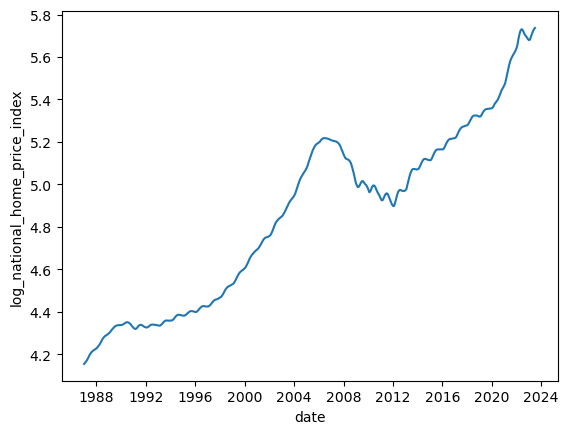

In [78]:
sns.lineplot(x = "date", y = "log_national_home_price_index", data = analyze_data)
plt.savefig("log_national_home_price_index.png")
plt.show()

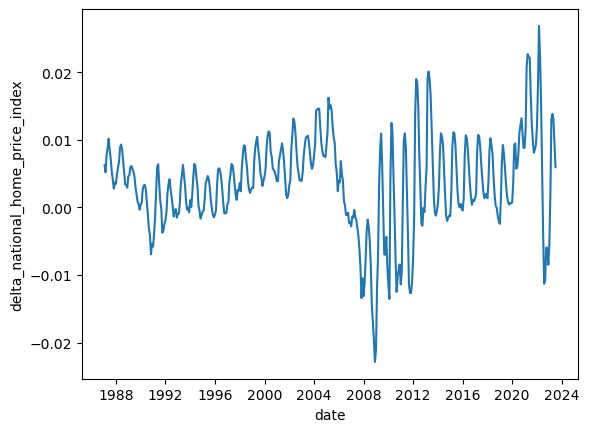

In [79]:
sns.lineplot(x = "date", y = "delta_national_home_price_index", data = analyze_data)
plt.savefig("delta_log_national_home_price_index.png")
plt.show()

## Descriptive Stats: If Stationary？

We can see from the graph that the indicators have significant trend. We expect that they are not stationary and need some adjustment later. 

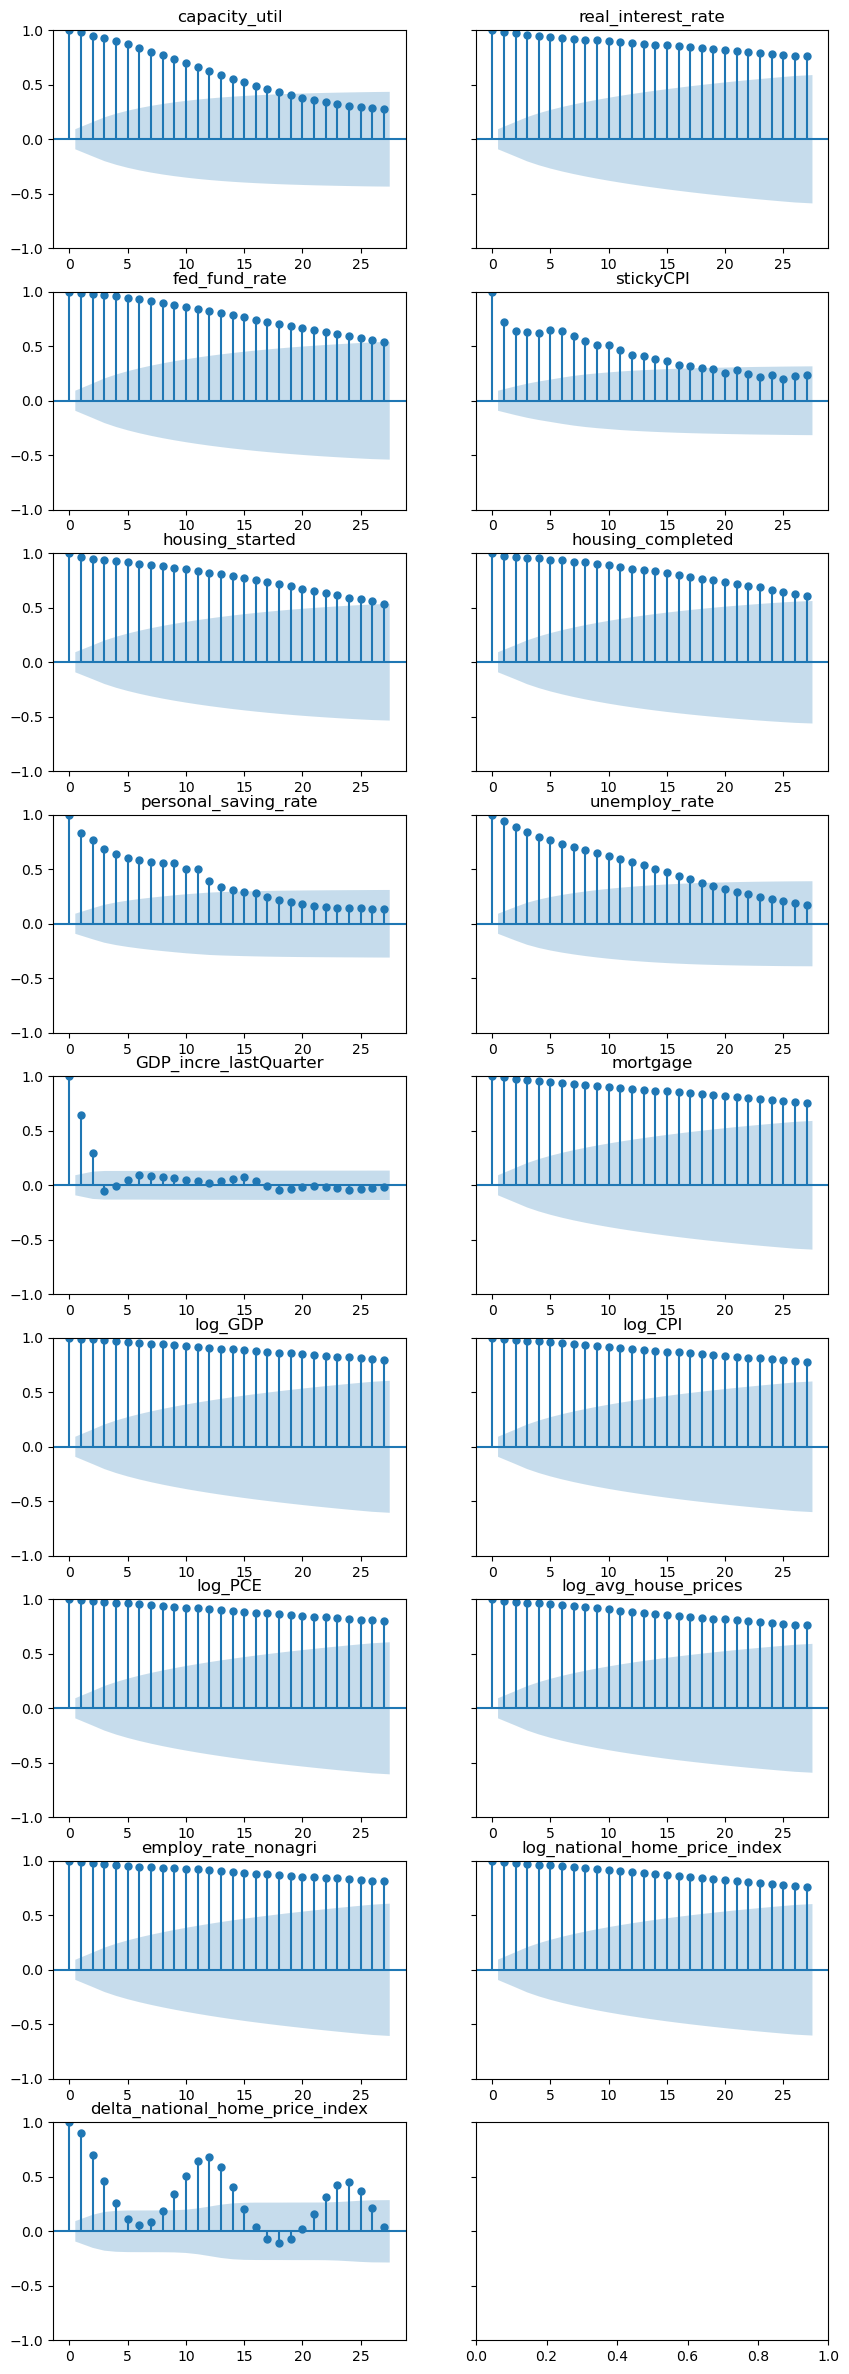

In [8]:
## autocorrelation 
variables = analyze_data.columns
fig, axs = plt.subplots(9, 2, sharey= True, figsize = (10,30))
for i in range(1,len(variables)):
    row = (i-1) // 2
    col = (i-1) % 2
    d = analyze_data[variables[i]].dropna()
    plot_acf(d, ax = axs[row,col], title = variables[i])
plt.show()

### Findings:

* All the marco indicators are not likely to be stationary without one-oder difference ,the autocorrelation coefficent decays linearly and slowly.
* Those indicators with one-oder difference is stationary : change rate is stationary. 
* National home price index may show some seasonality, with 12 months as a period. 

#### ADF test: Augmented Dickey-Fuller Unit Root Test

In [9]:
## adfuller test results
def adfuller_df(df):
    adftest = []
    variables = df.columns
    for var in variables[1:]:
        res = adfuller(df[var].dropna())
        if res[1] < 0.01:
            sig = "***"
        elif res[1] < 0.05:
            sig = "**"
        elif res[1] < 0.1:
            sig = "*"
        else:
            sig = "-"
        res_dict = adftest.append({"variable":var, "ADF stats": res[0], "p-value":res[1], "stationary":sig})
    return adftest 
    
adftest = adfuller_df(analyze_data)
adftest_result = pd.DataFrame(adftest).drop_duplicates() 
adftest_result

,variable,ADF stats,p-value,stationary
0,capacity_util,-3.050236,0.030462,**
1,real_interest_rate,-2.024542,0.275917,-
2,fed_fund_rate,-2.891258,0.046374,**
3,stickyCPI,-3.282932,0.015659,**
4,housing_started,-2.376407,0.148506,-
5,housing_completed,-2.355189,0.154785,-
6,personal_saving_rate,-3.412584,0.010537,**
7,unemploy_rate,-3.343796,0.013031,**
8,GDP_incre_lastQuarter,-4.299006,0.000446,***
9,mortgage,-1.769797,0.395556,-


In [10]:
### diff the non-stationary indicators
analyze_data["delta_real_interest_rate"] = analyze_data["real_interest_rate"].diff()
analyze_data["delta_housing_started"] = analyze_data["housing_started"].diff()
analyze_data["delta_housing_completed"] = analyze_data["housing_completed"].diff()
analyze_data["delta_logCPI"] = analyze_data["log_CPI"].diff()
analyze_data["delta_logPCE"] = analyze_data["log_PCE"].diff()
analyze_data["delta_employ_rate_nonagri"] = analyze_data["employ_rate_nonagri"].diff()
analyze_data["delta_mortgage"] = analyze_data["mortgage"].diff()
analyze_data["delta_avg_house_prices"] = analyze_data["log_avg_house_prices"].diff()

d = analyze_data.pop("delta_national_home_price_index")
analyze_data.insert(1,"delta_national_home_price_index",d)
d = analyze_data.pop("log_national_home_price_index")
analyze_data.insert(1,"log_national_home_price_index",d)

analyze_data.to_csv("../data/Analyze_data.csv", index = False)

##  Correlation & Cointegration

In [81]:
## correlation matrix
corr_df = analyze_data.dropna().corr()
corr_df

,log_national_home_price_index,delta_national_home_price_index,capacity_util,real_interest_rate,fed_fund_rate,stickyCPI,housing_started,housing_completed,personal_saving_rate,unemploy_rate,...,log_avg_house_prices,employ_rate_nonagri,delta_real_interest_rate,delta_housing_started,delta_housing_completed,delta_logCPI,delta_logPCE,delta_employ_rate_nonagri,delta_mortgage,delta_avg_house_prices
log_national_home_price_index,1.000000,0.113164,-0.515992,-0.828522,-0.664258,-0.146925,-0.045737,-0.110190,-0.167940,-0.157073,...,0.983035,0.893444,0.027269,-0.004856,0.008534,-0.018938,-0.037939,-0.008528,0.086824,0.002065
delta_national_home_price_index,0.113164,1.000000,0.030150,-0.078956,-0.075364,-0.006100,0.444235,0.292396,0.122008,-0.170822,...,0.126878,0.046125,0.090260,0.042786,0.077311,0.183697,0.090397,0.067389,0.176765,0.035458
capacity_util,-0.515992,0.030150,1.000000,0.697376,0.762462,0.458059,0.429616,0.423312,-0.132545,-0.543284,...,-0.500666,-0.660746,0.019071,-0.027702,-0.004712,0.219917,0.114869,0.036098,0.066481,0.000642
real_interest_rate,-0.828522,-0.078956,0.697376,1.000000,0.903136,0.429913,0.305061,0.449734,0.021667,-0.186932,...,-0.858443,-0.844357,0.064697,-0.059983,-0.033317,0.147292,0.063896,0.023760,0.009859,-0.020826
fed_fund_rate,-0.664258,-0.075364,0.762462,0.903136,1.000000,0.481802,0.351115,0.505298,-0.007148,-0.371072,...,-0.698377,-0.725929,-0.033256,-0.063585,-0.060955,0.188694,0.065853,0.030669,-0.023415,-0.022424
stickyCPI,-0.146925,-0.006100,0.458059,0.429913,0.481802,1.000000,0.247562,0.279088,-0.017279,-0.365521,...,-0.165532,-0.315727,0.043706,-0.005559,0.039686,0.426868,0.158440,0.047581,0.123657,-0.037338
housing_started,-0.045737,0.444235,0.429616,0.305061,0.351115,0.247562,1.000000,0.916221,-0.183890,-0.604129,...,-0.102705,-0.137223,0.084558,0.126749,0.075381,0.193816,0.142185,0.048003,0.136641,0.032538
housing_completed,-0.110190,0.292396,0.423312,0.449734,0.505298,0.279088,0.916221,1.000000,-0.217166,-0.581384,...,-0.200833,-0.174711,0.049260,-0.024840,0.105893,0.140759,0.093132,0.042320,0.084389,0.014591
personal_saving_rate,-0.167940,0.122008,-0.132545,0.021667,-0.007148,-0.017279,-0.183890,-0.217166,1.000000,0.438981,...,-0.134471,-0.294131,-0.020818,0.047552,0.035550,-0.050114,-0.053359,-0.001553,-0.105212,-0.004300
unemploy_rate,-0.157073,-0.170822,-0.543284,-0.186932,-0.371072,-0.365521,-0.604129,-0.581384,0.438981,1.000000,...,-0.157241,0.003058,-0.023200,0.036555,-0.000648,-0.139306,-0.052296,-0.026441,-0.105052,0.004082


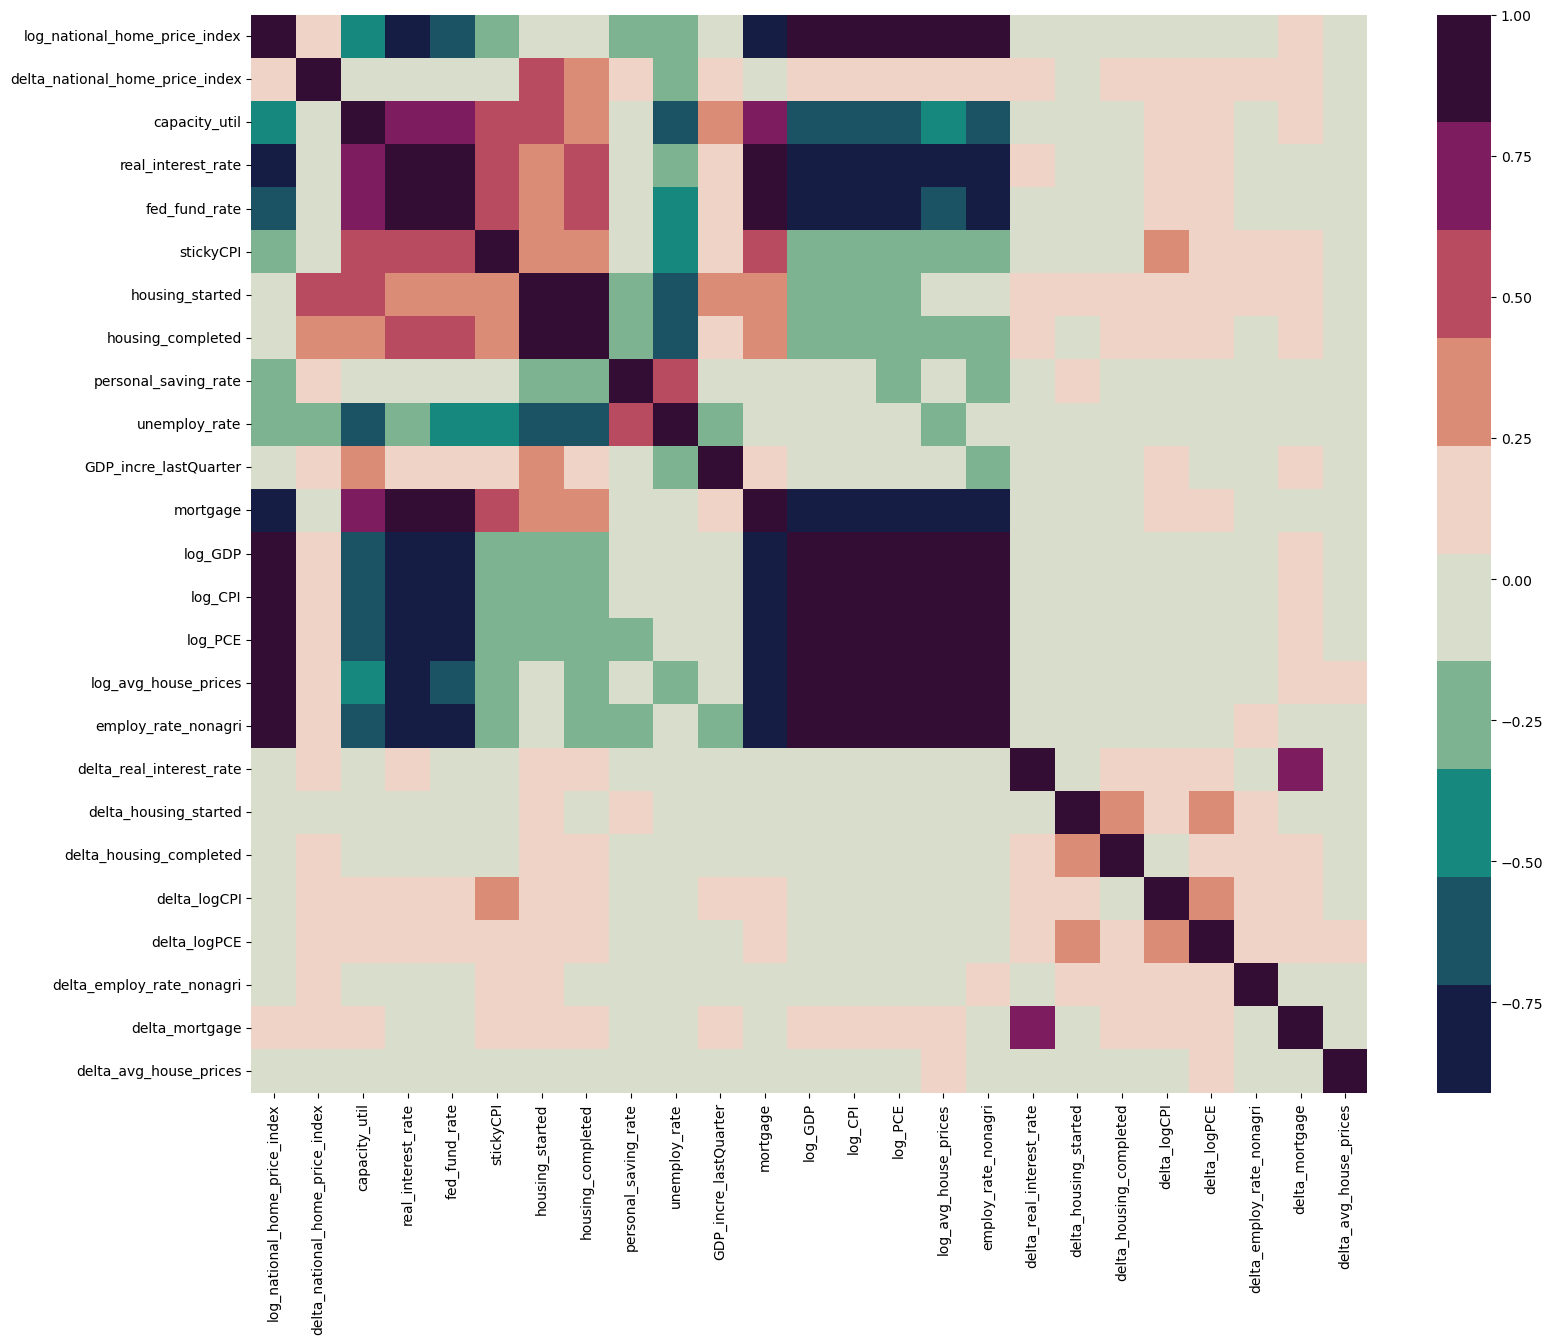

In [89]:
plt.figure(figsize = (18,14))
sns.heatmap(corr_df,cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)
plt.savefig("correlation matrix.png")

In [92]:
corr_df.loc["log_national_home_price_index",:].T

log_national_home_price_index      1.000000
delta_national_home_price_index    0.113164
capacity_util                     -0.515992
real_interest_rate                -0.828522
fed_fund_rate                     -0.664258
stickyCPI                         -0.146925
housing_started                   -0.045737
housing_completed                 -0.110190
personal_saving_rate              -0.167940
unemploy_rate                     -0.157073
GDP_incre_lastQuarter             -0.049027
mortgage                          -0.817675
log_GDP                            0.966125
log_CPI                            0.955809
log_PCE                            0.965764
log_avg_house_prices               0.983035
employ_rate_nonagri                0.893444
delta_real_interest_rate           0.027269
delta_housing_started             -0.004856
delta_housing_completed            0.008534
delta_logCPI                      -0.018938
delta_logPCE                      -0.037939
delta_employ_rate_nonagri       

In [14]:
np.sqrt(1 / 400)* 1.96 ## an estimation of significance 

0.098

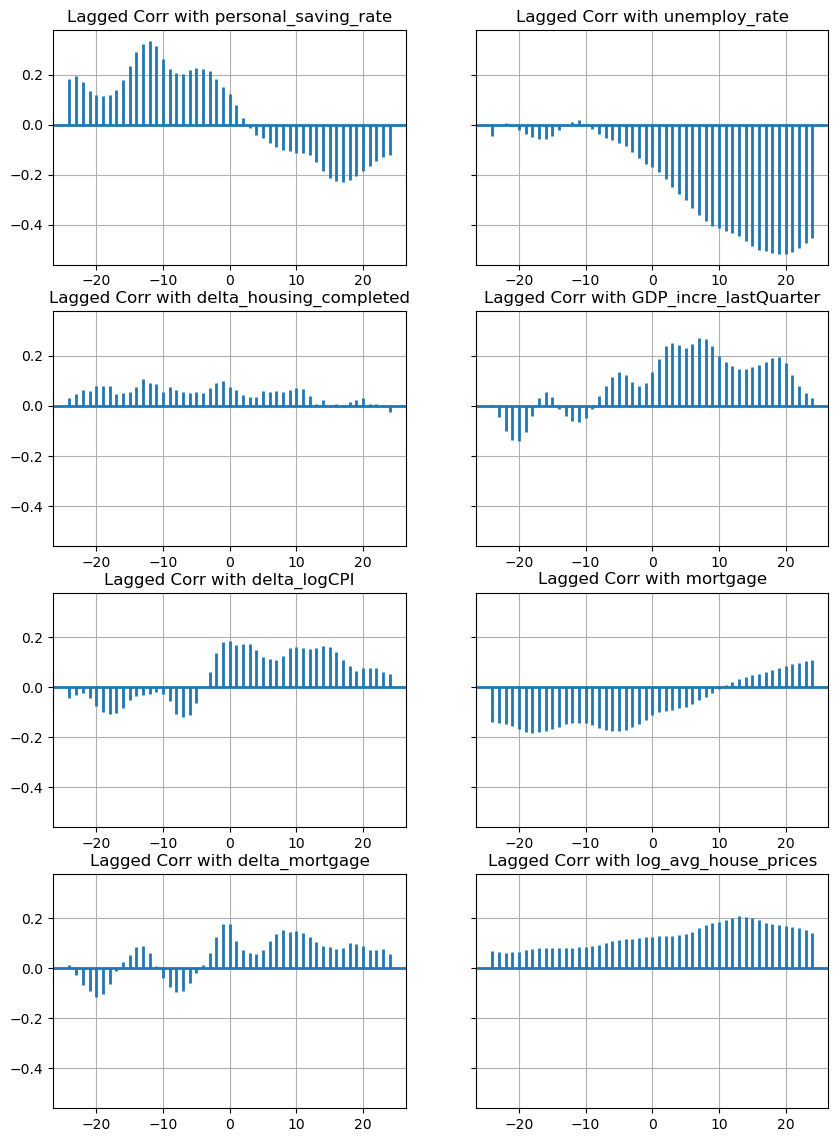

In [90]:
## Lagged Cross Correlation with national_home_price_index
## To find a propriate lag periods -- select some correlated variables from above matrix
variables = ["personal_saving_rate","unemploy_rate","delta_housing_completed",
            "GDP_incre_lastQuarter","delta_logCPI","mortgage", "delta_mortgage","log_avg_house_prices"]
fig, axs = plt.subplots(4, 2, sharey= True, figsize = (10,14))
for i in range(len(variables)):
    row = (i) // 2
    col = (i) % 2
    var = variables[i]
    ax = axs[row, col]
    d = analyze_data[["delta_national_home_price_index",var]].dropna()
    y = d["delta_national_home_price_index"] - d["delta_national_home_price_index"].mean()
    x = d[var] - d[var].mean()
    ax.xcorr(x, y, usevlines=True, maxlags=24, normed=True, lw=2)
    ax.grid(True)
    ax.set_title("Lagged Corr with " + var)
plt.savefig("lagged corr.png")
plt.show()

#### Cointegration Test with the non-diff series

In [16]:
### cointegration test -- whether there is false correlation
coint_test_data = analyze_data.copy().dropna().reset_index(drop = True).reset_index()
var_lists = [ 'capacity_util', 'real_interest_rate', 'fed_fund_rate','stickyCPI', 'housing_started', 'housing_completed',
       'personal_saving_rate', 'unemploy_rate', 'GDP_incre_lastQuarter','log_GDP', 'log_CPI', 'log_PCE', 'employ_rate_nonagri',
            "mortgage","log_avg_house_prices"]

def cointegration_test(var, coint_test_data, verbose = False):
    ## detrend
    ind = coint_test_data[["index"]]
    x_ind = sm.add_constant(ind)
    x_var = coint_test_data[var]
    y_var = coint_test_data["log_national_home_price_index"]
    lm_y = sm.OLS(y_var, x_ind).fit() 
    Y = lm_y.resid
    lm_x = sm.OLS(x_var ,x_ind).fit()
    X = sm.add_constant(lm_x.resid)
    
    lm = sm.OLS(Y,X).fit() ## regression with y = a + cX
    if verbose:
        print(lm.summary())
    resid = lm.resid       ## get the residuals
    p = adfuller(resid)[1] ## test whether the residuals is stationary
    sig = "**" if p < 0.05 else ("*" if p < 0.1 else "--")
    return {"variable":var, "p-value":p, "cointegrate":sig}

result = [cointegration_test(var, coint_test_data) for var in var_lists]
coint_result = pd.DataFrame(result)
coint_result

,variable,p-value,cointegrate
0,capacity_util,0.112000,--
1,real_interest_rate,0.243500,--
2,fed_fund_rate,0.238311,--
3,stickyCPI,0.218340,--
4,housing_started,0.012409,**
5,housing_completed,0.158691,--
6,personal_saving_rate,0.078044,*
7,unemploy_rate,0.185408,--
8,GDP_incre_lastQuarter,0.025197,**
9,log_GDP,0.013819,**


#### Assumption of the regression:
* Variables X are strictly exogenous. 
* We can get the X_t at the time we want to predict Y_t because the home price index is usually released later than the other indicators.  

## PCA： find economical fundamental factorsc from these indicators

In [95]:
### copy the data
pca_data = aligned_data.copy()
pca_data["log_national_home_price_index"] = np.log(pca_data["national_home_price_index"])
pca_data["delta_national_home_price_index"] = np.log(pca_data["national_home_price_index"]).diff()
var_lists = ["real_interest_rate","capacity_util","CPI","stickyCPI","PCE", "fed_fund_rate","unemploy_rate",
    "employ_level_nonagri", "employ_level", "housing_started","housing_completed","GDP","personal_saving_rate",
    "avg_house_prices","mortgage"]
vars_data = pca_data[var_lists].ffill()

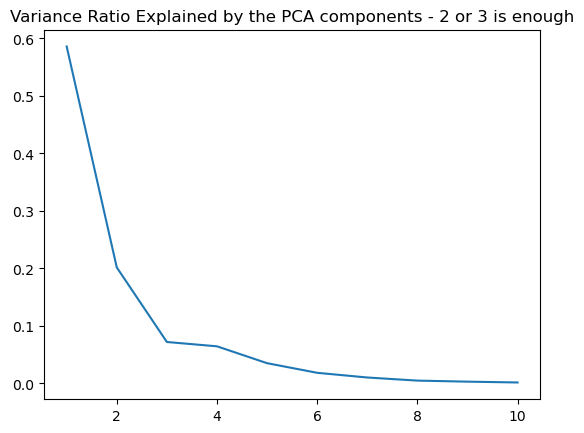

In [96]:
vars_data = (vars_data - vars_data.mean()) / vars_data.std() ## normalize
pca_model= PCA(n_components=10)
pca_model.fit(vars_data)
## plot the variance explained
plt.plot(range(1,len(pca_model.explained_variance_ratio_)+1),pca_model.explained_variance_ratio_)
plt.title("Variance Ratio Explained by the PCA components - 2 or 3 is enough")
plt.savefig("PCA variance explained.png")
plt.show()

In [97]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(vars_data)
principalDf = pd.DataFrame(data = principalComponents,columns = ['PC1', 'PC2',"PC3"])

In [98]:
### LOADINGS of PCA 
pd.DataFrame(pca.components_,columns = var_lists)

,real_interest_rate,capacity_util,CPI,stickyCPI,PCE,fed_fund_rate,unemploy_rate,employ_level_nonagri,employ_level,housing_started,housing_completed,GDP,personal_saving_rate,avg_house_prices,mortgage
0,0.323736,0.214402,-0.327952,0.129018,-0.321219,0.290916,-0.011108,-0.315659,-0.314783,0.119715,0.155377,-0.320372,0.038020,-0.303960,0.321579
1,-0.065561,-0.277615,-0.094571,-0.243219,-0.125273,-0.170692,0.527891,-0.182015,-0.186516,-0.413265,-0.399906,-0.127782,0.276314,-0.182984,-0.047356
2,0.100311,0.204029,0.121746,0.655462,0.169525,0.192053,-0.027844,-0.038959,-0.032438,-0.305401,-0.301540,0.174812,0.397935,0.209671,0.133490


* PCA1: focus on interest rate and growth
* PCA2: focus on unemployment, negative side of the economy
* PCA3: inflation 

In [99]:
lowdim_data = pca_data[["date","delta_national_home_price_index","log_national_home_price_index"]]
lowdim_data = pd.concat([lowdim_data, principalDf], axis = 1)
lowdim_data["delta_PC1"] = lowdim_data["PC1"].diff()
lowdim_data["delta_PC2"] = lowdim_data["PC2"].diff()
lowdim_data["delta_PC3"] = lowdim_data["PC3"].diff()
lowdim_data

,date,delta_national_home_price_index,log_national_home_price_index,PC1,PC2,PC3,delta_PC1,delta_PC2,delta_PC3
0,1986-01-01,NaN,NaN,5.581427,-0.169375,0.789936,NaN,NaN,NaN
1,1986-02-01,NaN,NaN,5.350647,0.478354,0.178671,-0.230779,0.647729,-0.611265
2,1986-03-01,NaN,NaN,5.240088,0.337575,0.815349,-0.110559,-0.140779,0.636678
3,1986-04-01,NaN,NaN,5.028772,0.424110,0.520820,-0.211316,0.086534,-0.294530
4,1986-05-01,NaN,NaN,4.885682,0.721885,-0.648562,-0.143090,0.297775,-1.169381
...,...,...,...,...,...,...,...,...,...
446,2023-03-01,0.013023,5.694802,-3.585965,-3.406567,2.015877,-0.073441,0.424054,-0.727907
447,2023-04-01,0.013842,5.708644,-3.742167,-3.248109,2.067831,-0.156202,0.158457,0.051954
448,2023-05-01,0.013047,5.721691,-3.638782,-3.430520,1.547303,0.103385,-0.182411,-0.520528
449,2023-06-01,0.009434,5.731125,-3.925449,-3.022124,1.063849,-0.286667,0.408396,-0.483454


In [100]:
## stationary test
adftest = adfuller_df(lowdim_data)
adftest_result = pd.DataFrame(adftest).drop_duplicates() 
adftest_result

,variable,ADF stats,p-value,stationary
0,delta_national_home_price_index,-3.601551,5.731440e-03,***
1,log_national_home_price_index,0.323645,9.784037e-01,-
2,PC1,-1.351303,6.053869e-01,-
3,PC2,-2.019917,2.779090e-01,-
4,PC3,-1.515841,5.256612e-01,-
5,delta_PC1,-26.523780,0.000000e+00,***
6,delta_PC2,-14.782274,2.235981e-27,***
7,delta_PC3,-14.412017,8.174867e-27,***


In [101]:
## correlation matrix
corr_df = lowdim_data.dropna().corr()
corr_df

,delta_national_home_price_index,log_national_home_price_index,PC1,PC2,PC3,delta_PC1,delta_PC2,delta_PC3
delta_national_home_price_index,1.000000,0.113164,-0.055693,-0.243699,-0.125347,0.115032,-0.090556,-0.000292
log_national_home_price_index,0.113164,1.000000,-0.918620,-0.296362,0.038710,0.020672,-0.014774,0.016226
PC1,-0.055693,-0.918620,1.000000,-0.013566,-0.002002,0.004488,0.010751,0.011098
PC2,-0.243699,-0.296362,-0.013566,1.000000,0.000897,-0.044722,0.152587,-0.028440
PC3,-0.125347,0.038710,-0.002002,0.000897,1.000000,0.131688,-0.061696,0.239516
delta_PC1,0.115032,0.020672,0.004488,-0.044722,0.131688,1.000000,-0.272012,0.632627
delta_PC2,-0.090556,-0.014774,0.010751,0.152587,-0.061696,-0.272012,1.000000,-0.195073
delta_PC3,-0.000292,0.016226,0.011098,-0.028440,0.239516,0.632627,-0.195073,1.000000


<AxesSubplot:>

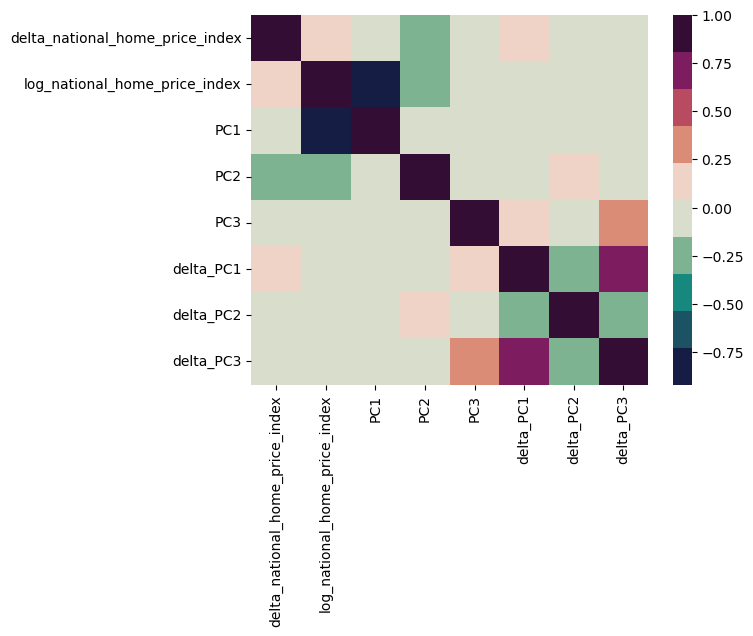

In [102]:
sns.heatmap(corr_df,cmap=palettable.cmocean.diverging.Curl_10.mpl_colors)

In [103]:
corr_df.loc[:,"delta_national_home_price_index"]

delta_national_home_price_index    1.000000
log_national_home_price_index      0.113164
PC1                               -0.055693
PC2                               -0.243699
PC3                               -0.125347
delta_PC1                          0.115032
delta_PC2                         -0.090556
delta_PC3                         -0.000292
Name: delta_national_home_price_index, dtype: float64

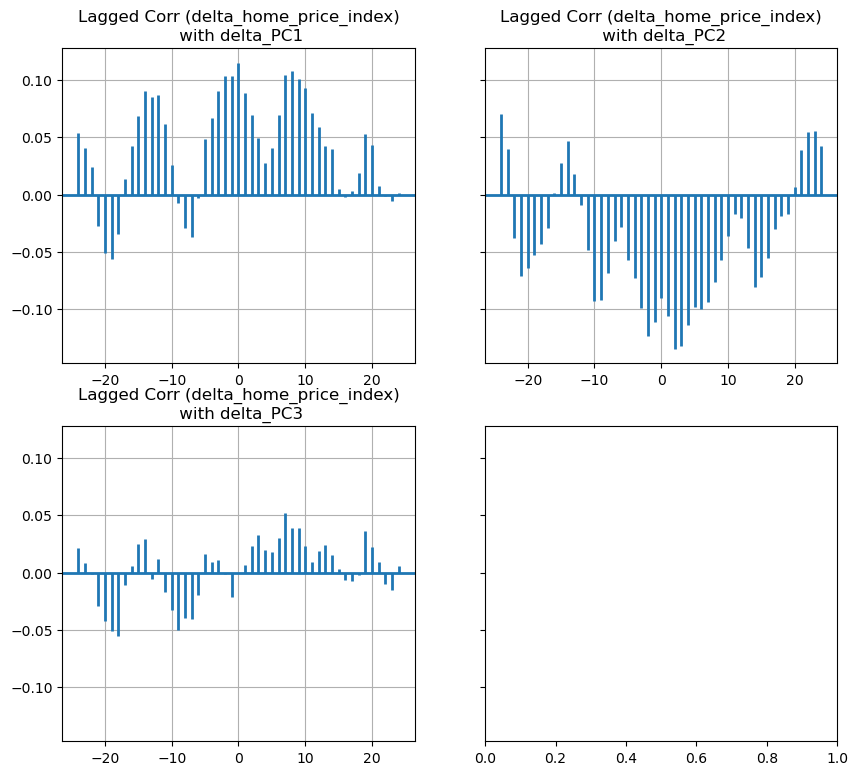

In [106]:
## Lagged Cross Correlation with national_home_price_index
variables = ["delta_PC1", "delta_PC2", "delta_PC3"]
fig, axs = plt.subplots(2, 2, sharey= True, figsize = (10,9))
for i in range(len(variables)):
    row = (i) // 2
    col = (i) % 2
    var = variables[i]
    ax = axs[row, col]
    d = lowdim_data[["delta_national_home_price_index",var]].dropna()
    y = d["delta_national_home_price_index"] - d["delta_national_home_price_index"].mean()
    x = d[var] - d[var].mean()
    ax.xcorr(x, y, usevlines=True, maxlags=24, normed=True, lw=2)
    ax.grid(True)
    ax.set_title("Lagged Corr (delta_home_price_index)\n with " + var)
plt.savefig("lag corr PCA.png")
plt.show()

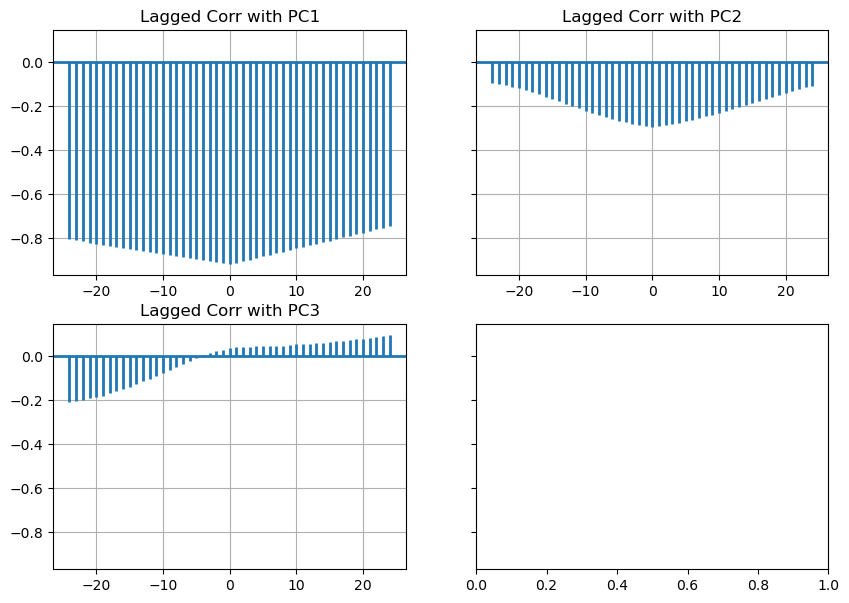

In [63]:
## Lagged Cross Correlation with log_national_home_price_index
variables = ["PC1", "PC2",  "PC3"]
fig, axs = plt.subplots(2, 2, sharey= True, figsize = (10,7))
for i in range(len(variables)):
    row = (i) // 2
    col = (i) % 2
    var = variables[i]
    ax = axs[row, col]
    d = lowdim_data[["log_national_home_price_index",var]].dropna()
    y = d["log_national_home_price_index"] - d["log_national_home_price_index"].mean()
    x = d[var] - d[var].mean()
    ax.xcorr(x, y, usevlines=True, maxlags=24, normed=True, lw=2)
    ax.grid(True)
    ax.set_title("Lagged Corr with " + var)
plt.show()

In [61]:
## conintegration
### cointegration test -- whether there is false correlation
coint_test_data = lowdim_data.copy().dropna().reset_index(drop = True).reset_index()
var_lists = [ "PC1","PC2","PC3"]

def cointegration_test(var, coint_test_data, verbose = False):
    ## detrend
    ind = coint_test_data[["index"]]
    x_ind = sm.add_constant(ind)
    x_var = coint_test_data[var]
    y_var = coint_test_data["log_national_home_price_index"]
    lm_y = sm.OLS(y_var, x_ind).fit() 
    Y = lm_y.resid
    lm_x = sm.OLS(x_var ,x_ind).fit()
    X = sm.add_constant(lm_x.resid)
    
    lm = sm.OLS(Y,X).fit() ## regression with y = a + cX
    if verbose:
        print(lm.summary())
    resid = lm.resid       ## get the residuals
    p = adfuller(resid)[1] ## test whether the residuals is stationary
    sig = "**" if p < 0.05 else ("*" if p < 0.1 else "--")
    return {"variable":var, "p-value":p, "cointegrate":sig}

result = [cointegration_test(var, coint_test_data) for var in var_lists]
coint_result = pd.DataFrame(result)
coint_result

,variable,p-value,cointegrate
0,PC1,0.297086,--
1,PC2,0.205280,--
2,PC3,0.079793,*


In [69]:
lowdim_data = lowdim_data.drop(["delta_national_home_price_index","log_national_home_price_index"], axis = 1)
lowdim_data.to_csv("../data/PCA_data.csv", index = False)